In [73]:
#Imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
from lmfit import Model
import emcee
from lmfit import fit_report
from scipy.optimize import minimize
from lmfit import Model, Parameters, Minimizer
import pandas as pd


In [74]:
#Read in .fits file (won't run in git directory)
fits_file = 'Reines_2020_sample/spec-ID-82.fits'
hdul = fits.open(fits_file)

# Display the file's contents
hdul.info()

Filename: Reines_2020_sample/spec-ID-82.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  COADD         1 BinTableHDU     26   3811R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


In [75]:
#get data extension and header
data2=hdul[1].data
header2= hdul[0].header
print(repr(header2))
print(np.shape(data2))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4648270752.62 / 1st row Number of seconds since Nov 17 1858    
RA      =            183.66102 / 1st row RA of telescope boresight (deg)        
DEC     =            29.921822 / 1st row Dec of telescope boresight (degrees)   
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '10:06:36.23'        / 1st row TAI time HH:MM:SS.SS                   
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                53799 / MJD of observation                             
MJDLIST = '53799   '        

In [76]:
# Extract the spectrum at this pixel
spectrum2 = data2['flux']
print("spectrum shape:", type(spectrum2))


# Get the wavelength solution from the header
coeff0 = header2['COEFF0']  # log10 of the starting wavelength
coeff1 = header2['COEFF1']  # log10 wavelength step per pixel

# Create the wavelength array
npix = spectrum2.shape[0]
loglam = coeff0 + coeff1 * np.arange(npix)
wavelength = 10 ** loglam  # convert log10(λ) to λ

print('wavelength shape:', np.shape(wavelength))
print(wavelength)

spectrum shape: <class 'numpy.ndarray'>
wavelength shape: (3811,)
[3801.89396321 3802.76948244 3803.64520329 ... 9136.92373681 9139.02783349
 9141.1324147 ]


## H-Beta

[3701.91623735 3702.7687332  3703.62142538 ... 8896.65168678 8898.7004524
 8900.74968981]


/tmp/ipykernel_131796/4004341631.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


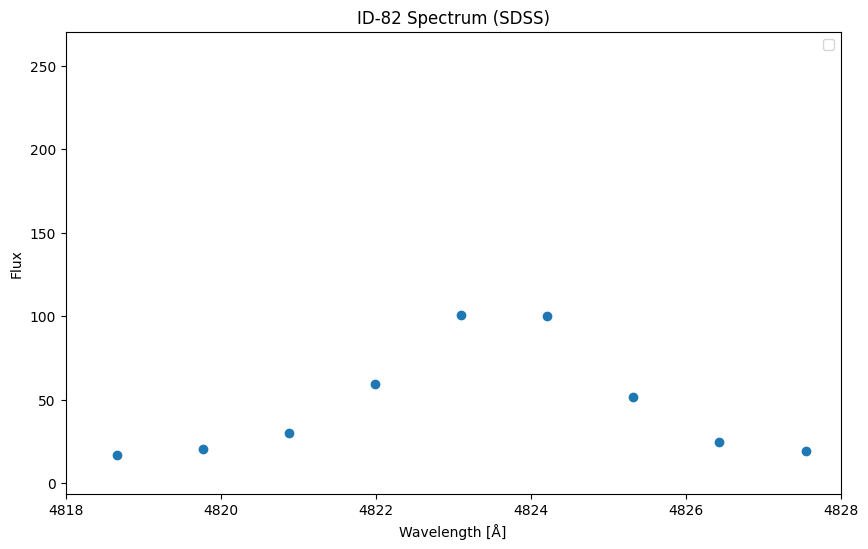

In [77]:
#Unredshift the data
z= 0.02700702 #SDSS
rest = wavelength/(z+1)
print(rest)

#Looking for H-Beta
plt.figure(figsize=(10, 6))
plt.scatter(rest, spectrum2)

plt.xlim(4818,4828)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.title('ID-82 Spectrum (SDSS)')
plt.legend()
plt.show()

In [78]:
#Define functions for fitting line and running MCMC
def fit_best_gaussian_model(x, y, max_components=5):
    best_bic = 1000000000 #initalize with a really large BIC
    best_model = None
    best_result = None

    n_points = len(x)

    for n in range(1, max_components + 1): #Loop through number of Gaussian Components
        n_params = n * 3
        if n_params >= n_points:
            continue  # Skip if too many parameters for the data

        model = None
        params = None
        for i in range(n):
            prefix = f'g{i}_' #Specific prefix for each gaussian component
            gmodel = GaussianModel(prefix=prefix)

            # Estimate amplitude, center, and sigma based on data
            amp_guess = np.max(y) / (n + 1)
            center_guess = x[np.argmax(y)]  # peak location
            sigma_guess = (x[-1] - x[0]) / (5 * (n + 1))  # broader for fewer components

            if model is None: #Intializes first Gaussian component
                model = gmodel
                params = gmodel.make_params(
                    amplitude=amp_guess,
                    center=center_guess,
                    sigma=sigma_guess
                )
            else: #make Gaussians 2+ (if applicable)
                center_offset = (x[-1] - x[0]) / (n + 1)
                center_guess = x[0] + (i + 0.5) * center_offset
                params.update(gmodel.make_params(
                    amplitude=amp_guess,
                    center=center_guess,
                    sigma=sigma_guess
                ))

            # Now, fit the model
        try:
            result = model.fit(y, params, x=x)
            bic = result.bic
            if bic < best_bic:
                best_bic = bic
                best_model = model
                best_result = result
                best_n= n
        except Exception as e:
            print(f"Fit failed for {n} components: {e}")

    print(f"############# Best Number of Gaussian Components= {best_n} ############# ")

    return best_model, best_result

def run_emcee(result, steps=1000, burn=300):

    params = result.params

    # Slightly perturb the initial parameters to initialize walkers
    for name, par in params.items():
        if par.vary:
            scatter = 0.01 * abs(par.value) if par.value != 0 else 0.01
            par.set(expr=None)  # Clear expressions if any
            par.min = par.value - 10 * scatter
            par.max = par.value + 10 * scatter

    emcee_kws = {
        'steps': steps,
        'burn': burn,
        'thin': 10,
        'is_weighted': False,
        'progress': True,
    }

    return result.emcee(params=params, **emcee_kws) #run MCMC

(9,)


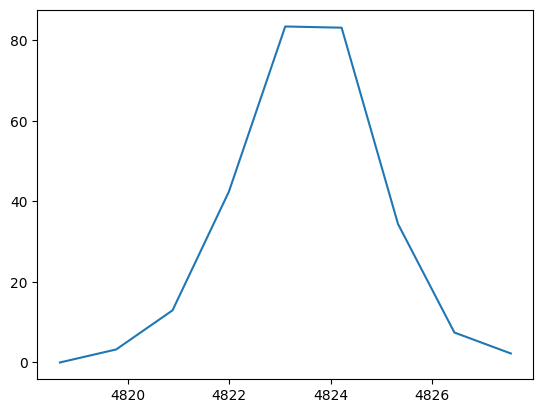

############# Best Number of Gaussian Components= 1 ############# 
[[Model]]
    Model(gaussian, prefix='g0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 9
    # variables        = 3
    chi-square         = 26.8260275
    reduced chi-square = 4.47100458
    Akaike info crit   = 15.8293321
    Bayesian info crit = 16.4210058
    R-squared          = 0.99703296
[[Variables]]
    g0_amplitude:  294.630534 +/- 5.84043474 (1.98%) (init = 41.7235)
    g0_center:     4823.57893 +/- 0.02956667 (0.00%) (init = 4823.104)
    g0_sigma:      1.29147654 +/- 0.02957645 (2.29%) (init = 0.8884486)
    g0_fwhm:       3.04119480 +/- 0.06964723 (2.29%) == '2.3548200*g0_sigma'
    g0_height:     91.0125571 +/- 1.80465043 (1.98%) == '0.3989423*g0_amplitude/max(1e-15, g0_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g0_amplitude, g0_sigma) = +0.5774


100%|██████████| 1000/1000 [00:06<00:00, 152.51it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.83943216 28.39866021 31.43996971 78.52534088]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 9
    # variables        = 4
    chi-square         = 5.35941280
    reduced chi-square = 1.07188256
    Akaike info crit   = 3.33466856
    Bayesian info crit = 4.12356687
[[Variables]]
    g0_amplitude:  294.403964 +/- 6.38551827 (2.17%) (init = 294.6305)
    g0_center:     4823.57902 +/- 0.03163461 (0.00%) (init = 4823.579)
    g0_sigma:      1.29337425 +/- 0.03265707 (2.52%) (init = 1.291477)
    g0_fwhm:       3.04566355 == '2.3548200*g0_sigma'
    g0_height:     90.8091333 == '0.3989423*g0_amplitude/max(1e-15, g0_sigma)'
    __lnsigma:     0.80630315 +/- 0.30493047 (37.82%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(g0_amplitude, g0_si

In [79]:
#Cut data to only have emission line and remove continuum 
line_indices= (rest > 4818) & (rest < 4828)

wavelength_line= rest[line_indices]
spectrum2_line = spectrum2[line_indices] 
print(np.shape(spectrum2_line))
spectrum2_line = spectrum2_line - spectrum2_line[0]

plt.plot(wavelength_line, spectrum2_line)
plt.show()

model, result = fit_best_gaussian_model(wavelength_line, spectrum2_line, max_components=4)
print(result.fit_report())

#Run MCMC to estimate errors
result_emcee = run_emcee(result)
print(fit_report(result_emcee))

#Print Measurements
def summarize(vals):
    vals = np.array(vals)
    return np.median(vals), np.std(vals)

def get_line_measurements_summarized(result):
    samples = result.flatchain

    output = []

    prefixes = set(k.split('_')[0] for k in result.params.keys())

    for prefix in prefixes:
        amp_key = f"{prefix}_amplitude"
        cen_key = f"{prefix}_center"
        sig_key = f"{prefix}_sigma"

        if amp_key not in samples or cen_key not in samples or sig_key not in samples:
            continue

        amps = samples[amp_key]
        cens = samples[cen_key]
        sigs = samples[sig_key]

        fluxes = amps
        fwhms = 2.3548 * sigs
        peak_fluxes = amps / (sigs * np.sqrt(2 * np.pi))  # <-- FIXED

        flux_med, flux_std = summarize(fluxes)
        center_med, center_std = summarize(cens)
        fwhm_med, fwhm_std = summarize(fwhms)
        peak_med, peak_std = summarize(peak_fluxes)

        output.append({
            "line": prefix,
            "flux": flux_med,
            "flux_err": flux_std,
            "center": center_med,
            "center_err": center_std,
            "fwhm": fwhm_med,
            "fwhm_err": fwhm_std,
            "peak_flux": peak_med,
            "peak_flux_err": peak_std,
        })

    return output



measurements = get_line_measurements_summarized(result_emcee)

for m in measurements:
    print(m)

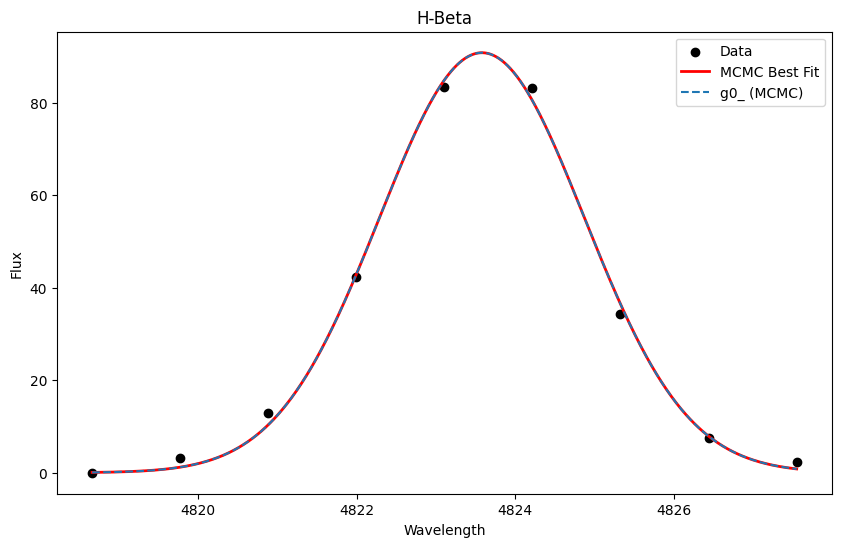

In [80]:
#Plot best fit and it's Gaussian components
median_params = result_emcee.params.copy()

for name in result_emcee.flatchain.columns:
    chain = result_emcee.flatchain[name]
    median_params[name].value = np.median(chain)

x_fit = np.linspace(min(wavelength_line), max(wavelength_line), 1000)
y_fit = result.model.eval(median_params, x=x_fit)

# Evaluate individual components if you want
components = result.model.eval_components(params=median_params, x=x_fit)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(wavelength_line, spectrum2_line, label='Data', color='black')
plt.plot(x_fit, y_fit, label='MCMC Best Fit', color='red', lw=2)

for name, comp in components.items():
    plt.plot(x_fit, comp, '--', label=f'{name} (MCMC)')

plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('H-Beta')
plt.show()

## [O I]

/tmp/ipykernel_131796/2319431840.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


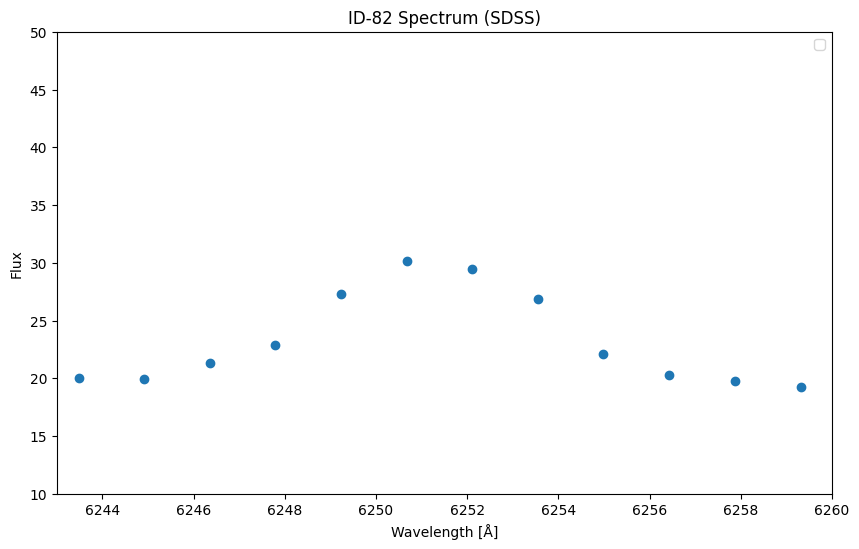

In [81]:
#Looking for [O I] line
plt.figure(figsize=(10, 6))
plt.scatter(rest, spectrum2)

plt.xlim(6243,6260)
plt.ylim(10,50)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.title('ID-82 Spectrum (SDSS)')
plt.legend()
plt.show()

(12,)


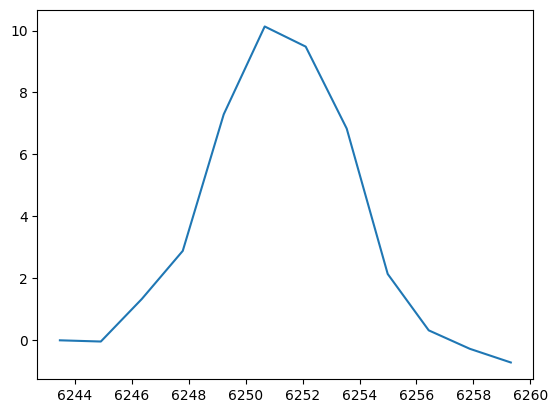

############# Best Number of Gaussian Components= 1 ############# 
[[Model]]
    Model(gaussian, prefix='g0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 12
    # variables        = 3
    chi-square         = 1.91092058
    reduced chi-square = 0.21232451
    Akaike info crit   = -16.0478586
    Bayesian info crit = -14.5931386
    R-squared          = 0.98929551
[[Variables]]
    g0_amplitude:  58.8686051 +/- 1.89935145 (3.23%) (init = 5.065663)
    g0_center:     6251.23825 +/- 0.08271882 (0.00%) (init = 6250.67)
    g0_sigma:      2.21988449 +/- 0.08271166 (3.73%) (init = 1.58338)
    g0_fwhm:       5.22742838 +/- 0.19477106 (3.73%) == '2.3548200*g0_sigma'
    g0_height:     10.5794589 +/- 0.34138349 (3.23%) == '0.3989423*g0_amplitude/max(1e-15, g0_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g0_amplitude, g0_sigma) = +0.5773


100%|██████████| 1000/1000 [00:06<00:00, 166.54it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.92218489 34.7558146  34.73629015 89.50677714]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 12
    # variables        = 4
    chi-square         = 8.42559781
    reduced chi-square = 1.05319973
    Akaike info crit   = 3.75641337
    Bayesian info crit = 5.69603997
[[Variables]]
    g0_amplitude:  58.8550788 +/- 1.85852306 (3.16%) (init = 58.86861)
    g0_center:     6251.23846 +/- 0.08587090 (0.00%) (init = 6251.238)
    g0_sigma:      2.22538778 +/- 0.07863612 (3.53%) (init = 2.219884)
    g0_fwhm:       5.24038765 == '2.3548200*g0_sigma'
    g0_height:     10.5508715 == '0.3989423*g0_amplitude/max(1e-15, g0_sigma)'
    __lnsigma:    -0.74140316 +/- 0.24732167 (33.36%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(g0_amplitude, g0_s

In [82]:
#Cut data to only [O I] and remove continuum
line_indices= (rest > 6243) & (rest < 6260)

wavelength_line= rest[line_indices]
spectrum2_line = spectrum2[line_indices] 
print(np.shape(spectrum2_line))
spectrum2_line = spectrum2_line - spectrum2_line[0]

plt.plot(wavelength_line, spectrum2_line)
plt.show()

model, result = fit_best_gaussian_model(wavelength_line, spectrum2_line, max_components=4) #fit model
print(result.fit_report())

#Run MCMC to estimate errors
result_emcee = run_emcee(result) #run MCMC on fit 
print(fit_report(result_emcee))

#Print Measurements
def summarize(vals):
    vals = np.array(vals)
    return np.median(vals), np.std(vals)

def get_line_measurements_summarized(result):
    samples = result.flatchain

    output = []

    prefixes = set(k.split('_')[0] for k in result.params.keys())

    for prefix in prefixes:
        amp_key = f"{prefix}_amplitude"
        cen_key = f"{prefix}_center"
        sig_key = f"{prefix}_sigma"

        if amp_key not in samples or cen_key not in samples or sig_key not in samples:
            continue

        amps = samples[amp_key]
        cens = samples[cen_key]
        sigs = samples[sig_key]

        fluxes = amps * sigs * np.sqrt(2 * np.pi)
        fwhms = 2.3548 * sigs

        flux_med, flux_std = summarize(fluxes)
        center_med, center_std = summarize(cens)
        fwhm_med, fwhm_std = summarize(fwhms)
        peak_med, peak_std = summarize(amps)

        output.append({
            "line": prefix,
            "flux": flux_med,
            "flux_err": flux_std,
            "center": center_med,
            "center_err": center_std,
            "fwhm": fwhm_med,
            "fwhm_err": fwhm_std,
            "peak_flux": peak_med,
            "peak_flux_err": peak_std,
        })

    return output

measurements = get_line_measurements_summarized(result_emcee)

for m in measurements:
    print(m)

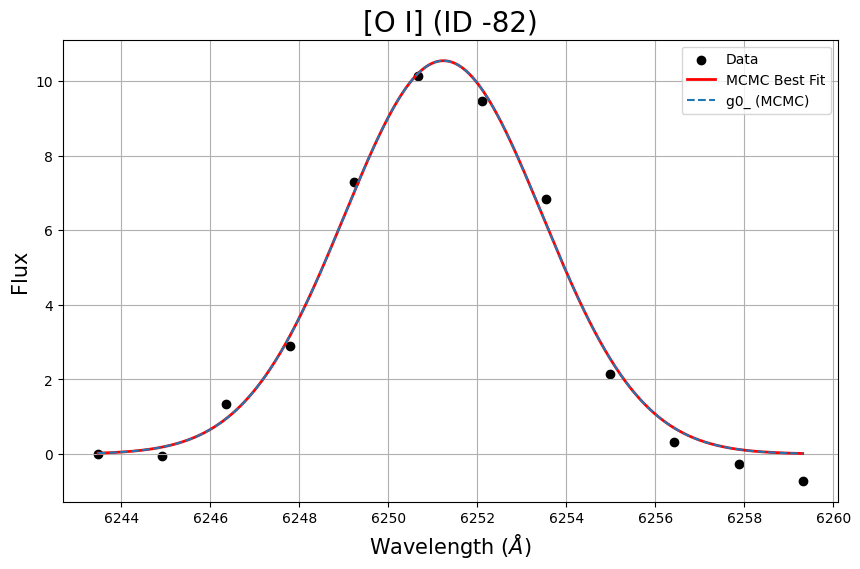

In [83]:
#Plot best fit and it's components
median_params = result_emcee.params.copy()

for name in result_emcee.flatchain.columns:
    chain = result_emcee.flatchain[name]
    median_params[name].value = np.median(chain)

x_fit = np.linspace(min(wavelength_line), max(wavelength_line), 1000)
y_fit = result.model.eval(median_params, x=x_fit)

# Evaluate individual components if you want
components = result.model.eval_components(params=median_params, x=x_fit)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(wavelength_line, spectrum2_line, label='Data', color='black')
plt.plot(x_fit, y_fit, label='MCMC Best Fit', color='red', lw=2)

for name, comp in components.items():
    plt.plot(x_fit, comp, '--', label=f'{name} (MCMC)')

plt.legend()
plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel('Flux', size=15)
plt.title('[O I] (ID -82)', size=20 )
plt.grid()
plt.show()

## SII Doublet

/tmp/ipykernel_131796/843272071.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


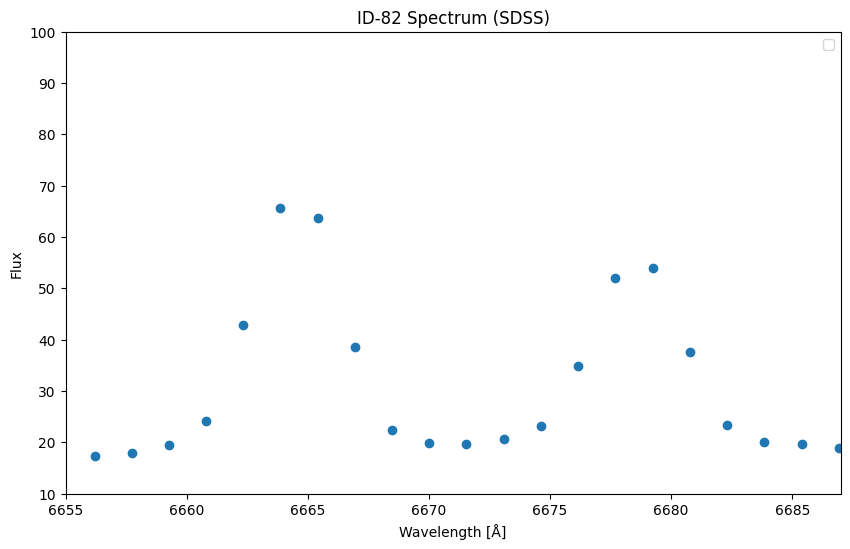

In [84]:
#Look for SII doublet
plt.figure(figsize=(10, 6))
plt.scatter(rest, spectrum2)

plt.xlim(6655,6687)
plt.ylim(10,100)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.title('ID-82 Spectrum (SDSS)')
plt.legend()
plt.show()

spectrum=[ 0.         0.52421    2.169794   6.785694  25.506136  48.25019
 46.32386   21.135145   5.0516586  2.5012703  2.2454586  3.2675648
  5.8015785 17.561525  34.560356  36.502426  20.230406   6.027092
  2.6763668  2.2325726  1.5984955]
(21,)


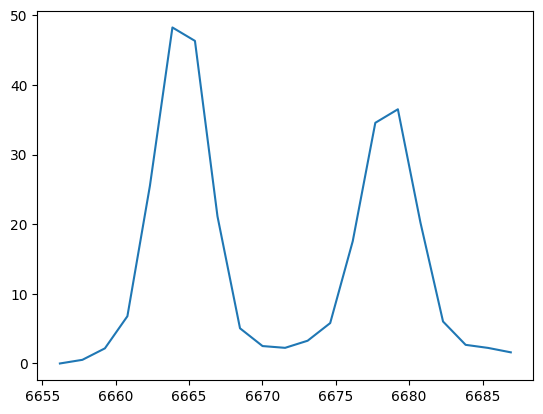

In [85]:
#Cut SII data and remove continuum
line_indices= (rest > 6655) & (rest < 6687)

wavelength_line= rest[line_indices]
spectrum2_line = spectrum2[line_indices] 
spectrum2_line = spectrum2_line - spectrum2_line[0]


print(f"spectrum={spectrum2_line}")
print(np.shape(spectrum2_line))


plt.plot(wavelength_line, spectrum2_line)
plt.show()

Components: 1, BIC: 35.29
Components: 2, BIC: 44.43
Components: 3, BIC: 38.17
[[Model]]
    (Model(gaussian, prefix='b0_') + Model(gaussian, prefix='r0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 21
    # variables        = 4
    chi-square         = 63.1339073
    reduced chi-square = 3.71375925
    Akaike info crit   = 31.1154465
    Bayesian info crit = 35.2935362
    R-squared          = 0.98729157
[[Variables]]
    amp_ratio:     0.76617741 +/- 0.03236268 (4.22%) (init = 1)
    b0_center:     6664.40175 +/- 0.05482255 (0.00%) (init = 6664)
    b0_sigma:      1.90152186 +/- 0.05481933 (2.88%) (init = 1)
    b0_amplitude:  241.429203 +/- 7.10811872 (2.94%) (init = 10)
    r0_center:     6678.78175 +/- 0.05482255 (0.00%) == 'b0_center + 14.38000000000011'
    r0_sigma:      1.90152186 +/- 0.05481933 (2.88%) == 'b0_sigma'
    r0_amplitude:  184.977601 +/- 6.75325165 (3.65%) == 'b0_amplitude * amp_ratio'
[[Correlations]] 

100%|██████████| 1000/1000 [00:09<00:00, 101.12it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 36.03985011  33.18533549  36.03176286  35.24870732 101.63309393]


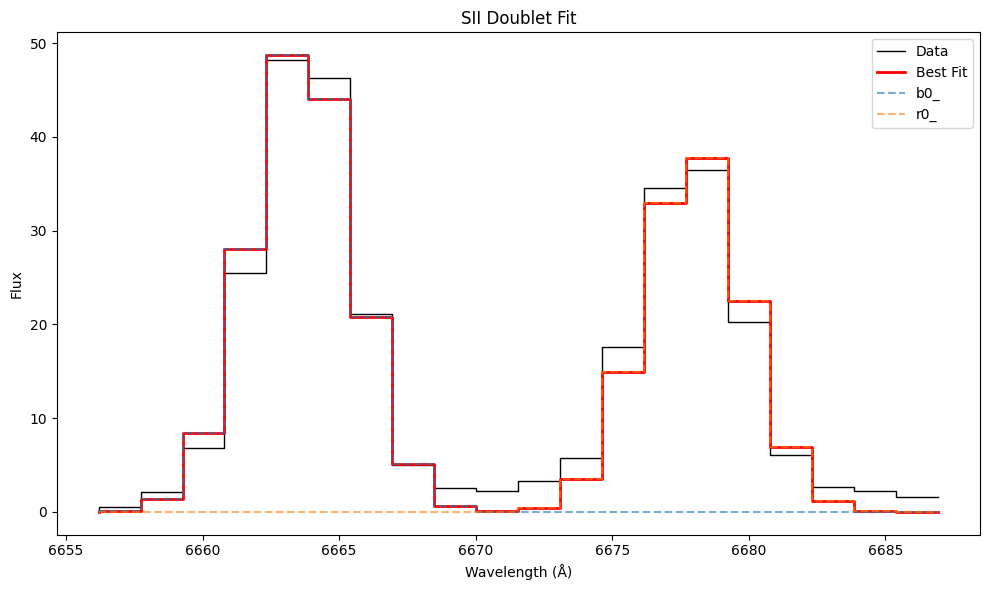

In [86]:
#Prompted to fix line profiles to match and to amke the fits more gaussian
def create_sii_model(n_components):
    model = None
    params = Parameters()

    # Global scaling factor between blue and red line profiles
    params.add('amp_ratio', value=1.0, min=0.01, max=5)

    for i in range(n_components):
        # Gaussian for blue line
        g_b = GaussianModel(prefix=f"b{i}_")
        model = g_b if model is None else model + g_b

        params.add(f"b{i}_center", value=SII_WAVELENGTHS[0], min=SII_WAVELENGTHS[0] - 2, max=SII_WAVELENGTHS[0] + 2)
        params.add(f"b{i}_sigma", value=1.0, min=0.3, max=5)
        params.add(f"b{i}_amplitude", value=10, min=0)

        # Gaussian for red line (same shape, just shifted and amplitude)
        g_r = GaussianModel(prefix=f"r{i}_")
        model += g_r

        params.add(f"r{i}_center", expr=f"b{i}_center + {SII_SEPARATION}")
        params.add(f"r{i}_sigma", expr=f"b{i}_sigma")
        params.add(f"r{i}_amplitude", expr=f"b{i}_amplitude * amp_ratio")

    return model, params

def compute_bic(residuals, n_params, n_points):
    rss = np.sum(residuals ** 2)
    bic = n_points * np.log(rss / n_points) + n_params * np.log(n_points)
    return bic

def fit_sii_doublet(wavelength, flux, flux_err=None, max_components=3):
    best_bic = np.inf
    best_result = None
    best_model = None

    for n in range(1, max_components + 1):
        model, params = create_sii_model(n)
        try:
            result = model.fit(flux, params, x=wavelength, weights=1 / flux_err if flux_err is not None else None)
            bic = compute_bic(result.residual, result.nvarys, len(wavelength))
            print(f"Components: {n}, BIC: {bic:.2f}")
            if bic < best_bic:
                best_bic = bic
                best_result = result
                best_model = model
        except Exception as e:
            print(f"Failed to fit with {n} components: {e}")
            continue

    return best_model, best_result

def run_mcmc(best_result, wavelength, flux):
    # Define residual function for MCMC
    def residual_func(params):
        model_flux = best_result.model.eval(params, x=wavelength)
        return model_flux - flux

    mini = Minimizer(residual_func, best_result.params)
    res = mini.emcee(burn=300, steps=1000, thin=10, is_weighted=False, progress=True)
    return res

def plot_fit(wavelength, flux, result, title="SII Doublet Fit"):
    plt.figure(figsize=(10, 6))
    plt.step(wavelength, flux, label='Data', color='black', lw=1)

    model_flux = result.model.eval(result.params, x=wavelength)
    plt.step(wavelength, model_flux, label='Best Fit', color='red', lw=2)

    comps = result.eval_components(x=wavelength)
    for name, comp in comps.items():
        plt.step(wavelength, comp, '--', label=name, alpha=0.6)

    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()






# --- Example Usage (with synthetic data for now) ---

# Constants

#For simulated data
SII_WAVELENGTHS = [6716.44, 6730.82]  # in Angstroms
SII_SEPARATION = SII_WAVELENGTHS[1] - SII_WAVELENGTHS[0]

#For ID-82
SII_WAVELENGTHS = [6664, 6678]  # in Angstroms

model, result = fit_sii_doublet(wavelength_line, spectrum2_line)
print(result.fit_report())

mcmc_result = run_mcmc(result, wavelength_line, spectrum2_line)
plot_fit(wavelength_line, spectrum2_line, result)

In [87]:
#Evaluate the full model
def get_line_measurements(mcmc_result, xdata, n_components=2, delta_lambda=14.38):

    chain = mcmc_result.flatchain
    amp_ratio = chain["amp_ratio"]

    results = []

    blue_fluxes, red_fluxes = [], []
    blue_centers, red_centers = [], []
    blue_fwhms, red_fwhms = [], []
    peak_blue_fluxes, peak_red_fluxes = [], []

    for idx in range(len(chain)):
        amps, sigmas, centers = [], [], []

        for i in range(n_components):
            amps.append(chain.iloc[idx][f"b{i}_amplitude"])
            sigmas.append(chain.iloc[idx][f"b{i}_sigma"])
            centers.append(chain.iloc[idx][f"b{i}_center"])

        amps = np.array(amps)
        sigmas = np.array(sigmas)
        centers = np.array(centers)

        # Blue line flux and center
        blue_flux = np.sum(amps * sigmas * np.sqrt(2 * np.pi))
        blue_center = np.sum(amps * sigmas * np.sqrt(2 * np.pi) * centers) / blue_flux
        blue_fwhm = np.sum(amps * sigmas * np.sqrt(2 * np.pi) * 2.355 * sigmas) / blue_flux

        # Red line
        red_center = blue_center + delta_lambda
        red_flux = np.sum(amps * amp_ratio.iloc[idx] * sigmas * np.sqrt(2 * np.pi))
        red_fwhm = blue_fwhm  # same profile

        # Create full model from Gaussians
        y_blue = np.zeros_like(xdata)
        y_red = np.zeros_like(xdata)
        for i in range(n_components):
            g = GaussianModel()
            y_blue += g.eval(x=xdata, amplitude=amps[i], center=centers[i], sigma=sigmas[i])
            y_red += g.eval(x=xdata, amplitude=amps[i] * amp_ratio.iloc[idx], center=centers[i] + delta_lambda, sigma=sigmas[i])

        # Peak flux = maximum value of full model
        peak_blue = np.max(y_blue)
        peak_red = np.max(y_red)

        blue_fluxes.append(blue_flux)
        red_fluxes.append(red_flux)
        blue_centers.append(blue_center)
        red_centers.append(red_center)
        blue_fwhms.append(blue_fwhm)
        red_fwhms.append(red_fwhm)
        peak_blue_fluxes.append(peak_blue)
        peak_red_fluxes.append(peak_red)

    def summarize(vals):
        vals = np.array(vals)
        return np.median(vals), np.std(vals)

    results.append({
        "line": "SII_6716",
        "flux": summarize(blue_fluxes)[0],
        "flux_err": summarize(blue_fluxes)[1],
        "center": summarize(blue_centers)[0],
        "center_err": summarize(blue_centers)[1],
        "fwhm": summarize(blue_fwhms)[0],
        "fwhm_err": summarize(blue_fwhms)[1],
        "peak_flux": summarize(peak_blue_fluxes)[0],
        "peak_flux_err": summarize(peak_blue_fluxes)[1],
    })

    results.append({
        "line": "SII_6731",
        "flux": summarize(red_fluxes)[0],
        "flux_err": summarize(red_fluxes)[1],
        "center": summarize(red_centers)[0],
        "center_err": summarize(red_centers)[1],
        "fwhm": summarize(red_fwhms)[0],
        "fwhm_err": summarize(red_fwhms)[1],
        "peak_flux": summarize(peak_red_fluxes)[0],
        "peak_flux_err": summarize(peak_red_fluxes)[1],
    })

    return pd.DataFrame(results)


print(get_line_measurements(mcmc_result, wavelength_line, n_components=1))

       line         flux   flux_err       center  center_err      fwhm  \
0  SII_6716  1154.878431  64.323162  6664.404059    0.059414  4.493338   
1  SII_6731   886.418441  53.955205  6678.784059    0.059414  4.493338   

   fwhm_err  peak_flux  peak_flux_err  
0  0.147639  48.544065       1.550463  
1  0.147639  37.673075       1.442397  


## OIII Doublet

/tmp/ipykernel_131796/672902585.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


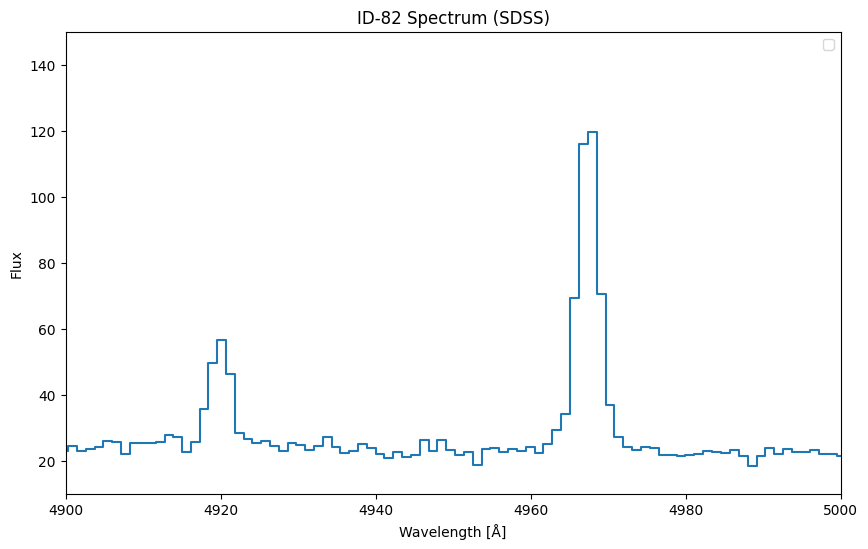

In [88]:
plt.figure(figsize=(10, 6))
plt.step(rest, spectrum2)

plt.xlim(4900,5000)
plt.ylim(10,150)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.title('ID-82 Spectrum (SDSS)')
plt.legend()
plt.show()

spectrum=[ 0.0000000e+00  3.1645679e+00  1.3193634e+01  2.7033752e+01
  3.3979828e+01  2.3816158e+01  5.9661884e+00  4.0200500e+00
  2.9035263e+00  3.2797508e+00  1.8435955e+00  3.4945679e-01
  2.7060833e+00  2.2709007e+00  5.5283737e-01  2.0270443e+00
  4.5392723e+00  1.4974308e+00 -1.8604660e-01  5.1731873e-01
  2.5417328e+00  1.3038216e+00 -5.6511688e-01 -1.6620865e+00
  4.1553497e-02 -1.4771118e+00 -9.6200562e-01  3.6029930e+00
  3.0761337e-01  3.6080990e+00  7.8178406e-01 -6.8226433e-01
  4.2701721e-02 -3.9966564e+00  1.1050854e+00  1.4044132e+00
  1.5733528e-01  9.8158455e-01  5.3598022e-01  1.5864983e+00
 -2.0905876e-01  2.4710789e+00  6.8678722e+00  1.1687477e+01
  4.6800243e+01  9.3425156e+01  9.6930481e+01  4.7916218e+01
  1.4373482e+01  4.6002350e+00  1.5703468e+00  7.3832703e-01]
(52,)


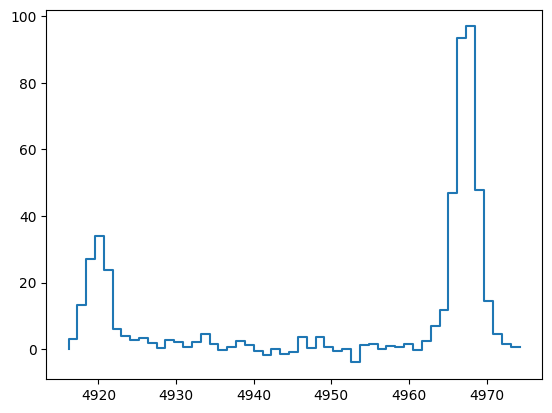

In [89]:
line_indices= (rest > 4916) & (rest < 4975)

wavelength_line= rest[line_indices]
spectrum2_line = spectrum2[line_indices] 
spectrum2_line = spectrum2_line - spectrum2_line[0]
print(f"spectrum={spectrum2_line}")
print(np.shape(spectrum2_line))


plt.step(wavelength_line, spectrum2_line)
plt.show()

Components: 1, BIC: 80.49
Components: 2, BIC: 77.38
Components: 3, BIC: 86.74


  0%|          | 0/1000 [00:00<?, ?it/s]/home/hernab6/anaconda3/envs/astr8070/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:13<00:00, 71.54it/s]
/home/hernab6/anaconda3/envs/astr8070/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [         nan          nan  63.30523401  55.05912682          nan
  57.76247203 130.7321104 ]


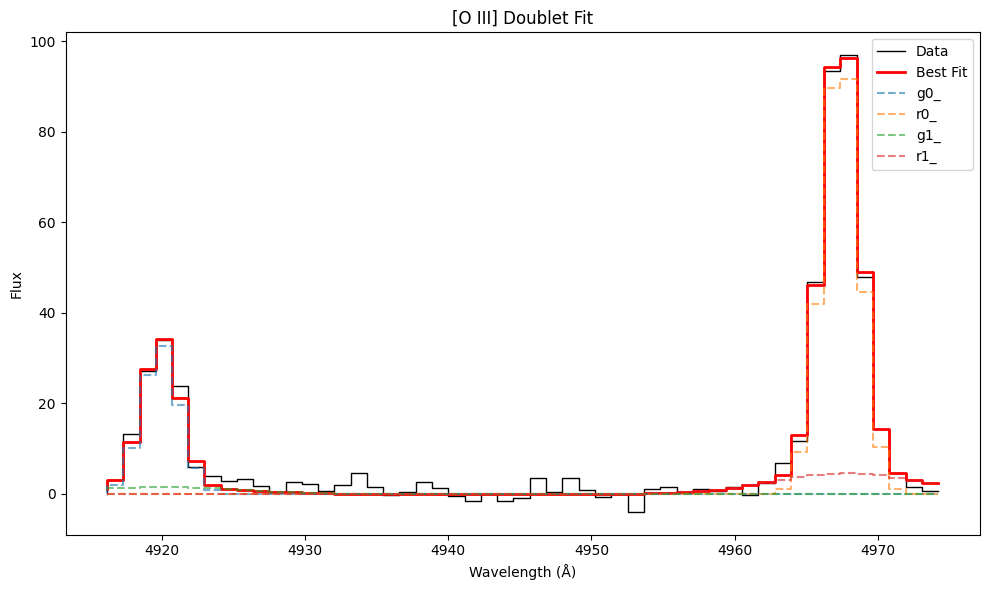

In [90]:
def create_oiii_model(n_components):
    model = None
    params = Parameters()

    for i in range(n_components):
        # Gaussian for 4959 line
        g_4959 = GaussianModel(prefix=f"g{i}_")
        model = g_4959 if model is None else model + g_4959

        params.add(f"g{i}_center", value=OIII_WAVELENGTHS[0], min=OIII_WAVELENGTHS[0] - 2, max=OIII_WAVELENGTHS[0] + 2)
        params.add(f"g{i}_sigma", value=1.0, min=0.3, max=5)
        params.add(f"g{i}_amplitude", value=10, min=0)

        # Corresponding Gaussian for 5007 line
        g_5007 = GaussianModel(prefix=f"r{i}_")
        model += g_5007

        params.add(f"r{i}_center", expr=f"g{i}_center + {OIII_SEPARATION}")
        params.add(f"r{i}_sigma", expr=f"g{i}_sigma")
        params.add(f"r{i}_amplitude", expr=f"g{i}_amplitude * {OIII_INTENSITY_RATIO}")

    return model, params

def compute_bic(residuals, n_params, n_points):
    rss = np.sum(residuals ** 2)
    bic = n_points * np.log(rss / n_points) + n_params * np.log(n_points)
    return bic

def fit_oiii_doublet(wavelength, flux, flux_err=None, max_components=3):
    best_bic = np.inf
    best_result = None
    best_model = None

    for n in range(1, max_components + 1):
        model, params = create_oiii_model(n)
        try:
            result = model.fit(flux, params, x=wavelength, weights=1 / flux_err if flux_err is not None else None)
            bic = compute_bic(result.residual, result.nvarys, len(wavelength))
            print(f"Components: {n}, BIC: {bic:.2f}")
            if bic < best_bic:
                best_bic = bic
                best_result = result
                best_model = model
        except Exception as e:
            print(f"Failed to fit with {n} components: {e}")
            continue

    return best_model, best_result

def run_mcmc(best_result, wavelength, flux):
    def residual_func(params):
        model_flux = best_result.model.eval(params, x=wavelength)
        return model_flux - flux

    mini = Minimizer(residual_func, best_result.params)
    res = mini.emcee(burn=300, steps=1000, thin=10, is_weighted=False, progress=True)
    return res

def plot_fit(wavelength, flux, result, title="[O III] Doublet Fit"):
    plt.figure(figsize=(10, 6))
    plt.step(wavelength, flux, label='Data', color='black', lw=1)

    model_flux = result.model.eval(result.params, x=wavelength)
    plt.step(wavelength, model_flux, label='Best Fit', color='red', lw=2)

    comps = result.eval_components(x=wavelength)
    for name, comp in comps.items():
        plt.step(wavelength, comp, '--', label=name, alpha=0.6)

    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Constants for [O III] doublet
#OIII_WAVELENGTHS = [4958.91, 5006.84]  # iTrue values
OIII_WAVELENGTHS=[4919, 4969]
OIII_SEPARATION = OIII_WAVELENGTHS[1] - OIII_WAVELENGTHS[0] - 2.5
OIII_INTENSITY_RATIO = 3.0  # 5007 / 4959

# Example Usage:
model, result = fit_oiii_doublet(wavelength_line, spectrum2_line)
mcmc_result = run_mcmc(result, wavelength_line, spectrum2_line)
plot_fit(wavelength_line, spectrum2_line, result)


In [91]:
def get_oiii_line_measurements(mcmc_result, xdata, n_components=2, delta_lambda=48.78, amp_ratio_fixed=3.0):
    chain = mcmc_result.flatchain

    results = []

    blue_fluxes, red_fluxes = [], []
    blue_centers, red_centers = [], []
    blue_fwhms, red_fwhms = [], []
    peak_blue_fluxes, peak_red_fluxes = [], []

    for idx in range(len(chain)):
        amps, sigmas, centers = [], [], []

        for i in range(n_components):
            amps.append(chain.iloc[idx][f"g{i}_amplitude"])
            sigmas.append(chain.iloc[idx][f"g{i}_sigma"])
            centers.append(chain.iloc[idx][f"g{i}_center"])

        amps = np.array(amps)
        sigmas = np.array(sigmas)
        centers = np.array(centers)

        # Blue line
        blue_flux = np.sum(amps * sigmas * np.sqrt(2 * np.pi))
        blue_center = np.sum(amps * sigmas * np.sqrt(2 * np.pi) * centers) / blue_flux
        blue_fwhm = np.sum(amps * sigmas * np.sqrt(2 * np.pi) * 2.355 * sigmas) / blue_flux

        # Red line (5007 Å)
        red_center = blue_center + delta_lambda
        red_flux = blue_flux * amp_ratio_fixed
        red_fwhm = blue_fwhm  # same profile

        # Create model to get peak values
        y_blue = np.zeros_like(xdata)
        y_red = np.zeros_like(xdata)
        for i in range(n_components):
            g = GaussianModel()
            y_blue += g.eval(x=xdata, amplitude=amps[i], center=centers[i], sigma=sigmas[i])
            y_red += g.eval(x=xdata, amplitude=amps[i] * amp_ratio_fixed, center=centers[i] + delta_lambda, sigma=sigmas[i])

        peak_blue = np.max(y_blue)
        peak_red = np.max(y_red)

        blue_fluxes.append(blue_flux)
        red_fluxes.append(red_flux)
        blue_centers.append(blue_center)
        red_centers.append(red_center)
        blue_fwhms.append(blue_fwhm)
        red_fwhms.append(red_fwhm)
        peak_blue_fluxes.append(peak_blue)
        peak_red_fluxes.append(peak_red)

    def summarize(vals):
        vals = np.array(vals)
        return np.median(vals), np.std(vals)

    results.append({
        "line": "OIII_4959",
        "flux": summarize(blue_fluxes)[0],
        "flux_err": summarize(blue_fluxes)[1],
        "center": summarize(blue_centers)[0],
        "center_err": summarize(blue_centers)[1],
        "fwhm": summarize(blue_fwhms)[0],
        "fwhm_err": summarize(blue_fwhms)[1],
        "peak_flux": summarize(peak_blue_fluxes)[0],
        "peak_flux_err": summarize(peak_blue_fluxes)[1],
    })

    results.append({
        "line": "OIII_5007",
        "flux": summarize(red_fluxes)[0],
        "flux_err": summarize(red_fluxes)[1],
        "center": summarize(red_centers)[0],
        "center_err": summarize(red_centers)[1],
        "fwhm": summarize(red_fwhms)[0],
        "fwhm_err": summarize(red_fwhms)[1],
        "peak_flux": summarize(peak_red_fluxes)[0],
        "peak_flux_err": summarize(peak_red_fluxes)[1],
    })

    return pd.DataFrame(results)

# Example usage:
print(get_oiii_line_measurements(mcmc_result, wavelength_line, n_components=2) )


        line         flux    flux_err       center  center_err      fwhm  \
0  OIII_4959   533.347436   50.100703  4920.408991    0.229483  5.008558   
1  OIII_5007  1600.042307  150.302110  4969.188991    0.229483  5.008558   

   fwhm_err  peak_flux  peak_flux_err  
0  0.827848  34.283914       0.499575  
1  0.827848  99.807583       1.491818  
